In [211]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import matplotlib.pyplot as plt 

import cv2
from PIL import Image

import SimpleITK as sitk
from torchio.transforms import Affine

from pathlib import Path

from bs4 import BeautifulSoup

In [209]:
def read_transform(file_name):
    
    with open(str(file_name), 'r') as f:
        data = f.read()

#print(data[12:])

    xml_data = BeautifulSoup(data[12:], "xml")

    #print(xml_data)

    x_dir = xml_data.find('direction0')
    y_dir = xml_data.find('direction1')
    z_dir = xml_data.find('direction2')

    x2 = [float(x_dir.get('x')), float(x_dir.get('y')), float(x_dir.get('z'))]
    y2 = [float(y_dir.get('x')), float(y_dir.get('y')), float(y_dir.get('z'))]
    z2 = [float(z_dir.get('x')), float(z_dir.get('y')), float(z_dir.get('z'))]
    
    f.close()
    
    return x2,y2,z2


def save_np_as_multitiff_stack(volume, file_name):
    
    imlist = []
    for i in range(volume.shape[0]):
        imlist.append(Image.fromarray(volume[i]))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])
    
    del imlist 
    

In [4]:
path = Path("c:\\Users\\fe0968\\Documents\\data\\medaka\\")


In [5]:
x = [1, 0, 0]

y = [0, 1, 0]

z = [0, 0, 1]



r1 = R.from_euler('xyz', [0, 45, 0], degrees=True)

x2 = r1.apply(x)
print(x2)

y2 = r1.apply(y)
print(y2)

z2 = r1.apply(z)
print(z2)

[ 0.70710678  0.         -0.70710678]
[0. 1. 0.]
[0.70710678 0.         0.70710678]


In [6]:
x2 = [0.70805369178113231, 3.7762687912420295e-17, -0.70615860085048132]
y2 = [0, 1, 0]
z2 = [0.70615860085048132, -2.9216395384872545e-17, 0.7080536917811322]

[-33.47867137  13.25431229  39.66602721]


In [57]:
sitk_image = sitk.ReadImage(path / 'landmarks' / 'example_landmarks_803_4-2_scale2_crop_rotated.tif')

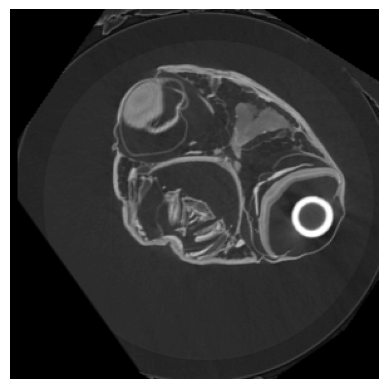

In [183]:
plt.imshow(sitk.GetArrayViewFromImage(sitk_image)[150], cmap= 'gray')
plt.axis('off');

In [217]:
#rotation_radians = np.radians(rotation_degrees).tolist()
#rotation_degrees = [0,0,0]


x2,y2,z2 = read_transform(path / 'transform.ORSObject')

#res_rot = R.align_vectors([x2,y2,z2], [x,y,z])
res_rot = R.align_vectors([z2,y2,x2], [z,y,x])
rotation_degrees = res_rot[0].as_euler('zyx', degrees=True)
print(rotation_degrees)

#degrees = [33,-11.22,45.36]
degrees = -rotation_degrees
#degrees[1] = -degrees[1] 

print(degrees)

img_rotation = Affine(scales=[1.0, 1.0, 1.0], degrees=degrees, translation=[0,0,0],
                              center='image')

#pos_rotation = sitk.Euler3DTransform()
#pos_rotation.SetRotation(*rotation_radians)

image_data = sitk.GetArrayFromImage(sitk_image).astype('uint8')
#image_data = sitk.GetArrayFromImage(sitk_im<age).transpose(2, 1, 0).astype('uint8')
print('Image shape', image_data.shape)

image_rotated = img_rotation(np.expand_dims(image_data, axis=0))[0]
print('Image shape', image_rotated.shape)
print(image_rotated.dtype)

#result_image = sitk.GetImageFromArray(image_rotated.transpose(2, 1, 0))


[-33.77449055  12.7349661    0.23461687]
[ 33.77449055 -12.7349661   -0.23461687]
Image shape (380, 295, 294)
Image shape (380, 295, 294)
float32


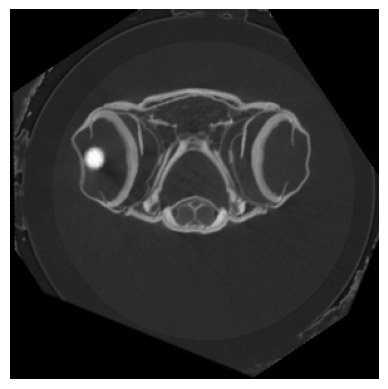

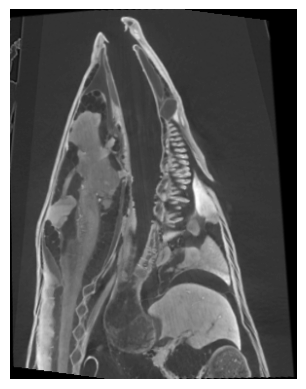

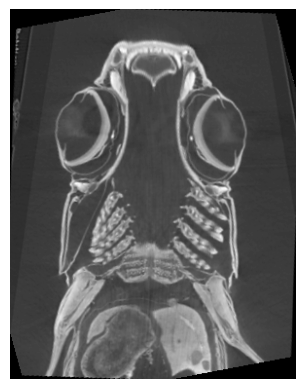

In [214]:
plt.imshow(image_rotated[100], cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(image_rotated[:,:,140], cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(image_rotated[:,140,:], cmap='gray')
plt.axis('off')
plt.show()

In [218]:
save_np_as_multitiff_stack(image_rotated.astype('uint8'), f'test_rotated.tif')

In [220]:
# open file in write mode
with open('info.txt', 'w') as fp:
    for item in degrees:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


## Dragonfly script 

In [3]:
from OrsHelpers.viewLogger import ViewLogger
from OrsPlugins.orsimageloader import OrsImageLoader
from OrsHelpers.managedhelper import ManagedHelper
from OrsHelpers.datasethelper import DatasetHelper
from OrsHelpers.layoutpropertieshelper import LayoutPropertiesHelper
from OrsPythonPlugins.OrsObjectPropertiesList.OrsObjectPropertiesList import OrsObjectPropertiesList
from OrsPythonPlugins.OrsDerivedDataset.OrsDerivedDataset import OrsDerivedDataset
from OrsHelpers.roihelper import ROIHelper
from OrsHelpers.structuredGridLogger import StructuredGridLogger
from OrsHelpers.structuredGridHelper import StructuredGridHelper
from OrsHelpers.reporthelper import ReportHelper
from PIL import Image
import math

ModuleNotFoundError: No module named 'OrsHelpers'

In [225]:
#--------------------------------------------------------------
# Global settings
#--------------------------------------------------------------
PATH_INPUT_FOLDER = 'c:/Users/fe0968/Documents/data/medaka/landmarks/data_for_workshop/scaled/'
PATH_OUTPUT_INFO_FOLDER = 'c:/Users/fe0968/Documents/data/medaka/landmarks/data_for_workshop/scaled/'

#SPACING = 1.23e-06 # Pixel size in micrometers
SPACING = 1 # Pixel size in micrometers

def get_volume_size(volume_path):

    im = Image.open(volume_path)
    return (im.size[0], im.size[1], im.n_frames)

def load_volume(volume_file_name = 'fA2p0_17_2_s_eig16_new_sagittal.tif'):

    fileNamesListElement = PATH_INPUT_FOLDER + volume_file_name
    fileNames = [fileNamesListElement]

    vol_size = get_volume_size(PATH_INPUT_FOLDER + volume_file_name)

    #xSize = 1048
    #ySize = 1140
    #zSize = 1116

    xSize = vol_size[0]
    ySize = vol_size[1]
    zSize = vol_size[2]
    tSize = 1
    minX = 0
    maxX = xSize -1
    minY = 0
    maxY = ySize -1
    minZ = 0
    maxZ = zSize -1
    xSampling = 1
    ySampling = 1
    zSampling = 1
    tSampling = 1
    xSpacing = SPACING
    ySpacing = SPACING
    zSpacing = SPACING
    slope = 1.0
    offset = 0.0
    dataUnit = ''
    invertX = False
    invertY = False
    invertZ = False
    axesTransformation = 0
    datasetName = volume_file_name
    convertFrom32To16bits = False
    dataRangeMin = 0.0
    dataRangeMax = 0.0
    frameCount = 1

    additionalInfo = 'PD94bWwgdmVyc2lvbj0iMS4wIj8+CjxJbWFnZUxvYWRlck1vZGVsIElzRGF0YVJHQj0iZmFsc2UiIFJHQk91dHB1dD0iMCIgSW52ZXJ0SW50ZW5zaXR5PSJmYWxzZSIgLz4K'


    output = OrsImageLoader.createDatasetFromFiles(fileNames=fileNames,
                                                xSize=xSize,
                                                ySize=ySize,
                                                zSize=zSize,
                                                tSize=tSize,
                                                minX=minX,
                                                maxX=maxX,
                                                minY=minY,
                                                maxY=maxY,
                                                minZ=minZ,
                                                maxZ=maxZ,
                                                xSampling=xSampling,
                                                ySampling=ySampling,
                                                zSampling=zSampling,
                                                tSampling=tSampling,
                                                xSpacing=xSpacing,
                                                ySpacing=ySpacing,
                                                zSpacing=zSpacing,
                                                slope=slope,
                                                offset=offset,
                                                dataUnit=dataUnit,
                                                invertX=invertX,
                                                invertY=invertY,
                                                invertZ=invertZ,
                                                axesTransformation=axesTransformation,
                                                datasetName=datasetName,
                                                convertFrom32To16bits=convertFrom32To16bits,
                                                dataRangeMin=dataRangeMin,
                                                dataRangeMax=dataRangeMax,
                                                frameCount=frameCount,
                                                additionalInfo=additionalInfo)

    volume_channel = output[0]
    ManagedHelper.publish(anObject=volume_channel)

    name = 'toplayout\\scene_0'
    isVisible = True
    
    DatasetHelper.setIsVisibleIn2DFromGenealogicalName(name=name,
                                                    dataset=volume_channel,
                                                    isVisible=isVisible)

  

    layoutFullName = 'toplayout\\scene_0'
    lutUUID = '7b00da82eefc11e68693448a5b87686a'
    aScalarValueTypeTag = ''
 
    LayoutPropertiesHelper.set3DLUTUUIDFromGenealogicalName(layoutFullName=layoutFullName,
                                                            anObject=volume_channel,
                                                            lutUUID=lutUUID,
                                                            aScalarValueTypeTag=aScalarValueTypeTag)


    return volume_channel

def make_copy(dataset):
    
    d = DatasetHelper.copyDataset(aDataset=dataset)
    
    d.setTitle(newVal='aligned', logging=True)
    
    d.publish(logging=True)
    
    name = 'toplayout\\scene_0'

    DatasetHelper.setIsVisibleIn2DFromGenealogicalName(name=name,
                                                       dataset=d,
                                                       isVisible=True)
    return d

def resample(orig_dataset, resampled_dataset):
    newTitle_3 = 'aligned (Resampled)'


    derivedDataset = OrsDerivedDataset.copyStructuredGridIntoAnotherShape(sourceStructuredGrid=resampled_dataset,
                                                                         referenceStructureGrid=orig_dataset,
                                                                         newTitle=newTitle_3)
    
    derivedDataset.publish(logging=True)
    
    name = 'toplayout\\scene_0'

    DatasetHelper.setIsVisibleIn2DFromGenealogicalName(name=name,
                                                       dataset=derivedDataset,
                                                       isVisible=True)
    
    return derivedDataset

def save_crop_box_info(im, file_name='crop'):
    v,d = StructuredGridHelper.getClipBoxForCurrentView(im)
    b = v.getBox(0)
    
    crop_info = {'x': int(b.getOrigin().getX() + 0.5),
                'y': int(b.getOrigin().getY() + 0.5),
                'z': int(b.getOrigin().getZ() + 0.5),
                'w': math.floor(b.getDirection0Size() + 0.5),
                'h': math.floor(b.getDirection1Size() + 0.5),
                'd': math.floor(b.getDirection2Size() + 0.5)
                    }
    
    with open(PATH_OUTPUT_INFO_FOLDER + file_name + '.txt', "w") as fp:
        json.dump(crop_info, fp)  # encode dict into JSON 
    
    
def save_rotation(im, file_name='rot'):
    b = im.getBox()
    
    x_dir = b.getDirection0()
    y_dir = b.getDirection1()
    z_dir = b.getDirection2()
    
    rotation_info = {'x_dir': {'x': x_dir.getX(), 'y': x_dir.getY(), 'z': z_dir.getZ()},
                     'y_dir': {'x': y_dir.getX(), 'y': y_dir.getY(), 'z': y_dir.getZ()},
                     'z_dir': {'x': z_dir.getX(), 'y': z_dir.getY(), 'z': z_dir.getZ()}
                    }
    
    with open(PATH_OUTPUT_INFO_FOLDER + file_name + '.txt', "w") as fp:
        json.dump(rotation_info, fp)  # encode dict into JSON      

In [ ]:
def save_rotation(im, file_name='rot'):
    b = im.getBox()
    
    x_dir = b.getDirection0()
    y_dir = b.getDirection1()
    z_dir = b.getDirection2()
    
    rotation_info = {'x_dir': {'x': x_dir.getX(), 'y': x_dir.getY(), 'z': z_dir.getZ()},
                     'y_dir': {'x': y_dir.getX(), 'y': y_dir.getY(), 'z': y_dir.getZ()},
                     'z_dir': {'x': z_dir.getX(), 'y': z_dir.getY(), 'z': z_dir.getZ()}
                    }
    
    with open(PATH_OUTPUT_INFO_FOLDER + file_name + '.txt', "w") as fp:
        json.dump(rotation_info, fp)  # encode dict into JSON   

In [ ]:
b = im.getBox()
x = b.getDirection0().getX()
print(x)

In [1]:
import pickle

# create a dictionary using {}
person = {"name": "Jessa", "country": "USA", "telephone": 1178}
print('Person dictionary')
print(person)

# save dictionary to person_data.pkl file
with open('person_data.pkl', 'wb') as fp:
    pickle.dump(person, fp)
    print('dictionary saved successfully to file')

Person dictionary
{'name': 'Jessa', 'country': 'USA', 'telephone': 1178}
dictionary saved successfully to file


In [2]:
import json

# assume you have the following dictionary
person = {"name": "Jessa", "country": "USA", "telephone": 1178}
print('Person dictionary')
print(person)

print("Started writing dictionary to a file")
with open("person.txt", "w") as fp:
    json.dump(person, fp)  # encode dict into JSON
print("Done writing dict into .txt file")

Person dictionary
{'name': 'Jessa', 'country': 'USA', 'telephone': 1178}
Started writing dictionary to a file
Done writing dict into .txt file
